# Homework 4

Due date: May 26, 2024

### Submission instructions: 
- __Autograder will not be used for scoring, but you still need to submit the python file converted from this notebook (.py) and the notebook file (.ipynb) to the code submission window.__ 
To convert a Jupyter Notebook (`.ipynb`) to a regular Python script (`.py`):
  - In Jupyter Notebook: File > Download as > Python (.py)
  - In JupyterLab: File > Save and Export Notebook As... > Executable Script
  - In VS Code Jupyter Notebook App: In the toolbar, there is an Export menu. Click on it, and select Python script.
- Submit `hw4.ipynb` and `hw4.py` on Gradescope under the window "Homework 4 - code". Do **NOT** change the file name.
- Convert this notebook into a pdf file and submit it on Gradescope under the window "Homework 4 - PDF". Make sure all your code and text outputs in the problems are visible. 


### General instructions: 

In this homework, we will use pandas to build a cohort of ICU stays and visualize the results from the MIMIC-IV dataset, which you did for Homework 3 in BIOSTAT 203B. 

For processing the Parquet files, one other option is [`polars`](https://pola.rs/). The package is designed for rapid analysis of data frames, possibly larger than memory, with pandas-like syntax, Apache Arrow-based data representation and the Rust language as its backend. Syntax is similar to what you have used for `pyarrow`. You are allowed to use any method you like for analyzing data, but use of `pyarrow`, `duckdb`, or `polars` is certainly recommended for larger files to save your memory and time. (_Hint_: If you want to try `polars`, look into `scan_parquet()` and `LazyFrame`. The package `polars` supports lazy evaluation similar to what you have seen in the R `arrow` package.)

For visualization, you may use packages `matplotlib`, `seaborn`, and/or `plotly`. The use of `plotnine` is not allowed.

Please run the code below to show your system information:

In [110]:
import platform, psutil, json
def get_system_info():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['architecture']=platform.machine()
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        for k, v in info.items():
            print(f"{k}:\t{v}")
    except Exception as e:
        logging.exception(e)

In [111]:
get_system_info()

platform:	Darwin
platform-release:	23.2.0
platform-version:	Darwin Kernel Version 23.2.0: Wed Nov 15 21:59:33 PST 2023; root:xnu-10002.61.3~2/RELEASE_ARM64_T8112
architecture:	arm64
processor:	arm
ram:	8 GB


In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import pyarrow as pa
import duckdb
import plotly.express as px

## Problem 1. Visualizing patient trajectory

Visualizing a patient’s encounters in a health care system is a common task in clinical data analysis. In this question, we will visualize a patient’s ADT (admission-discharge-transfer) history and ICU vitals in the MIMIC-IV data.

### (A). ADT history
A patient’s ADT history records the time of admission, discharge, and transfer in the hospital. This figure shows the ADT history of the patient with subject_id `10001217` in the MIMIC-IV data. The x-axis is the calendar time, and the y-axis is the type of event (ADT, lab, procedure). The color of the line segment represents the care unit. The size of the line segment represents whether the care unit is an ICU/CCU. The crosses represent lab events, and the shape of the dots represents the type of procedure. The title of the figure shows the patient’s demographic information and the subtitle shows top 3 diagnoses. Try to create a figure similar to the below:

<figure>
  <img src="https://raw.githubusercontent.com/ucla-biostat-203b/2024winter/main/hw/hw3/10001217_adt.png" style="width:600px">
</figure>


Your figure does not need to be the same, but all the information in this figure should be reasonably arranged in your figure. Hint: consider using `dodge` keyword arguments of seaborn to do something similar to `jitter` of `ggplot2`. 



Hint: We need to pull information from data files `patients.csv.gz`, `admissions.csv.gz`, `transfers.csv.gz`, `labevents.csv.gz`, `procedures_icd.csv.gz`, `diagnoses_icd.csv.gz`, `d_icd_procedures.csv.gz`, and `d_icd_diagnoses.csv.gz`. For the big file `labevents.csv.gz`, use the Parquet file you generated in Homework 3. More information is available in later problems.

For reproducibility, make the Parquet file available at the current working directory, for example, by a symbolic link. Make your code reproducible using relative path.

Do a similar visualization for the patient `10013310`.

In [113]:
# Interested patient
sid = 10001217

In [114]:
# Import transfers.csv.gz and filter for the specific patient
sid_adt = pd.read_csv("~/mimic/hosp/transfers.csv.gz")

# Filter for the specific patient
sid_adt = sid_adt[sid_adt['subject_id'] == sid]

# Convert 'intime' and 'outtime' to datetime format and filter out 'discharge' events
sid_adt['intime'] = pd.to_datetime(sid_adt['intime'], utc=True)
sid_adt['outtime'] = pd.to_datetime(sid_adt['outtime'], utc=True)
sid_adt = sid_adt[sid_adt['eventtype'] != 'discharge']

# Display the DataFrame
print(sid_adt)

     subject_id     hadm_id  transfer_id eventtype  \
184    10001217  24597018.0     30437372  transfer   
186    10001217  24597018.0     35343802  transfer   
187    10001217  24597018.0     37058438     admit   
188    10001217  24597018.0     37067082  transfer   
189    10001217  24597018.0     39866888        ED   
190    10001217  27703517.0     33261790     admit   
191    10001217  27703517.0     34592300  transfer   
192    10001217  27703517.0     34609030  transfer   
194    10001217  27703517.0     37436471  transfer   
195    10001217         NaN     39300221        ED   

                                careunit                    intime  \
184                            Neurology 2157-11-24 15:32:32+00:00   
186                            Neurology 2157-11-21 22:08:00+00:00   
187                             Medicine 2157-11-19 01:24:00+00:00   
188  Surgical Intensive Care Unit (SICU) 2157-11-20 19:18:02+00:00   
189                 Emergency Department 2157-11-18 17:

In [115]:
import os

# Define paths
original_path = os.path.expanduser("~/Desktop/203c/hw3/labevents.parquet")
link_path = os.path.expanduser("~/Desktop/203c/hw4/labevents.parquet")

# Check if the original path exists
if not os.path.exists(original_path):
    raise FileNotFoundError(f"The file {original_path} does not exist.")

# Create a symbolic link if it doesn't already exist
if not os.path.exists(link_path):
    os.symlink(original_path, link_path)

In [116]:
import pyarrow.dataset as ds

# Load the dataset using pyarrow.dataset
dataset = ds.dataset("labevents.parquet", format="parquet")

# Filter for the specific patient
filtered_table = dataset.to_table(filter=(ds.field('subject_id') == sid))

# Convert to a pandas DataFrame
sid_lab = filtered_table.to_pandas()

# Convert 'charttime' and 'storetime' to datetime format
sid_lab['charttime'] = pd.to_datetime(sid_lab['charttime'], utc=True)
sid_lab['storetime'] = pd.to_datetime(sid_lab['storetime'], utc=True)

# Display the DataFrame
print(sid_lab)

     labevent_id  subject_id     hadm_id  specimen_id  itemid  \
0           8945    10001217         NaN     17915844   50887   
1           8946    10001217         NaN     27706469   51146   
2           8947    10001217         NaN     27706469   51200   
3           8948    10001217         NaN     27706469   51221   
4           8949    10001217         NaN     27706469   51222   
..           ...         ...         ...          ...     ...   
348         9294    10001217  27703517.0     73688730   51265   
349         9295    10001217  27703517.0     73688730   51277   
350         9296    10001217  27703517.0     73688730   51279   
351         9297    10001217  27703517.0     73688730   51301   
352         9298    10001217  27703517.0     86955433   51009   

    order_provider_id                 charttime                 storetime  \
0                     2157-11-18 18:30:00+00:00                       NaT   
1                     2157-11-18 18:30:00+00:00 2157-11-18 18:56:

In [117]:
# Import procedures_icd.csv.gz and filter for the specific patient
sid_procedure = pd.read_csv("~/mimic/hosp/procedures_icd.csv.gz")

# Filter for the specific patient
sid_procedure = sid_procedure[sid_procedure['subject_id'] == sid]

# Convert 'chartdate' to datetime format
sid_procedure['chartdate'] = pd.to_datetime(sid_procedure['chartdate'], utc=True)

# Load d_icd_procedures.csv.gz
procedure = pd.read_csv("~/mimic/hosp/d_icd_procedures.csv.gz")

# Join sid_procedure with procedure on 'icd_code'
sid_procedure = sid_procedure.merge(procedure, on="icd_code", how="left")

# Display the DataFrame
print(sid_procedure)

   subject_id   hadm_id  seq_num                 chartdate icd_code  \
0    10001217  24597018        1 2157-11-20 00:00:00+00:00     0139   
1    10001217  24597018        2 2157-11-19 00:00:00+00:00     0331   
2    10001217  24597018        3 2157-11-22 00:00:00+00:00     3897   
3    10001217  27703517        1 2157-12-19 00:00:00+00:00     0139   

   icd_version_x  icd_version_y  \
0              9              9   
1              9              9   
2              9              9   
3              9              9   

                                        long_title  
0                          Other incision of brain  
1                                       Spinal tap  
2  Central venous catheter placement with guidance  
3                          Other incision of brain  


In [118]:
# Load diagnoses_icd.csv.gz
sid_diagnosis = pd.read_csv("~/mimic/hosp/diagnoses_icd.csv.gz")

# Filter for the specific patient
sid_diagnosis = sid_diagnosis[sid_diagnosis['subject_id'] == sid]

# Load d_icd_diagnoses.csv.gz
sid_d = pd.read_csv("~/mimic/hosp/d_icd_diagnoses.csv.gz")

# Join sid_diagnosis with sid_d on 'icd_code'
sid_diagnosis = sid_diagnosis.merge(sid_d, on="icd_code", how="left")

# Obtain the top three diagnoses
top_three = sid_diagnosis.head(3)['long_title'].tolist()

# Display the top three diagnoses
print(top_three)

['Intracranial abscess', 'Compression of brain', 'Cerebral edema']


In [119]:
# Load patients.csv.gz
patient = pd.read_csv("~/mimic/hosp/patients.csv.gz")

# Filter for the specific patient
patient = patient[patient['subject_id'] == sid]

# Obtain gender and age
gender = patient['gender'].values[0]
age = patient['anchor_age'].values[0]

# Display the gender and age
print(f"Gender: {gender}")
print(f"Age: {age}")

Gender: F
Age: 55


In [120]:
# Load admissions.csv.gz
admission = pd.read_csv("~/mimic/hosp/admissions.csv.gz")

# Filter for the specific patient
admission = admission[admission['subject_id'] == sid]

# Obtain race
race = admission['race'].values[0]

# Display the race
print(f"Race: {race}")

Race: WHITE


In [121]:
sid_adt['intime']=pd.to_datetime(sid_adt['intime'])
sid_adt['outtime']=pd.to_datetime(sid_adt['outtime'])
admission['admittime']=pd.to_datetime(admission['admittime'])
admission['dischtime']=pd.to_datetime(admission['dischtime'])
sid_lab['charttime']=pd.to_datetime(sid_lab['charttime'])
sid_procedure['chartdate']=pd.to_datetime(sid_procedure['chartdate'])

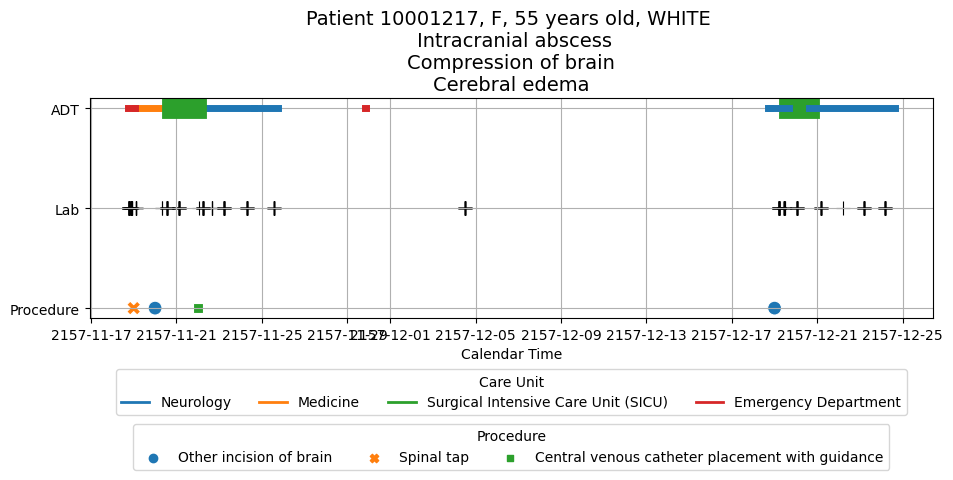

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert 'line' values to boolean for linewidth control
sid_adt['line'] = sid_adt['careunit'].str.contains("ICU|CCU")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot ADT segments with unique colors for each care unit
careunit_colors = {careunit: color for careunit, color in zip(sid_adt['careunit'].unique(), sns.color_palette("tab10", len(sid_adt['careunit'].unique())))}

for _, row in sid_adt.iterrows():
    ax.plot([row['intime'], row['outtime']], ["ADT", "ADT"],
            color=careunit_colors[row['careunit']],
            linewidth=15 if row['line'] else 5)

# Plot Lab events
sns.scatterplot(x='charttime', y=['Lab']*len(sid_lab), data=sid_lab, marker='+', color='black', s=100, ax=ax)

# Plot Procedures with dodge
sns.scatterplot(x='chartdate', y=['Procedure']*len(sid_procedure), hue='long_title', data=sid_procedure, s=100, ax=ax, style="long_title")

# Customize the plot
ax.set_xlabel("Calendar Time")
ax.set_ylabel("")
subtitle = "\n".join(top_three)
ax.set_title(f"Patient {sid}, {gender}, {age} years old, {race} \n {subtitle}", fontsize=14)
# fig.text(0.5, 1, subtitle, ha='left', fontsize=10)

# Y-axis ticks
ax.set_yticks(["Procedure", "Lab", "ADT"])

# Adding the care unit legend
careunit_handles = [plt.Line2D([0], [0], color=careunit_colors[cu], lw=2) for cu in careunit_colors]
careunit_labels = list(careunit_colors.keys())
careunit_legend = ax.legend(careunit_handles, careunit_labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, title='Care Unit')

# Adding the procedure legend
procedure_handles, procedure_labels = ax.get_legend_handles_labels()
procedure_legend = ax.legend(procedure_handles, procedure_labels, loc='upper center', bbox_to_anchor=(0.5, -0.45), ncol=4, title='Procedure')

# Adding both legends to the plot
ax.add_artist(careunit_legend)

# Final plot adjustments
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust rect to fit legends in the figure

# Show the plot
plt.show()


### (B). ICU stays
ICU stays are a subset of ADT history. This figure shows the vitals of the patient `10001217` during ICU stays. The x-axis is the calendar time, and the y-axis is the value of the vital. The color of the line represents the type of vital. The facet grid shows the abbreviation of the vital and the stay ID. These vitals are: heart rate (220045), systolic non-invasive blood pressure (220179), diastolic non-invasive blood pressure (220180), body temperature in Fahrenheit (223761), and respiratory rate (220210). Try to create a figure similar to below:


<figure>
  <img src="https://raw.githubusercontent.com/ucla-biostat-203b/2024winter/main/hw/hw3/10001217_icu.png" style="width:600px">
</figure>

Repeat a similar visualization for the patient `10013310`.

In [123]:
import pyarrow.dataset as ds
import pandas as pd

# Load the dataset with pyarrow
chartevents_tble = ds.dataset("chartevents.parquet", format="parquet")
itemid_list = [220045, 220179, 220180, 223761, 220210]

# Convert to pandas DataFrame and filter based on subject_id and itemid
chartevents_sid = chartevents_tble.to_table(filter=(ds.field("subject_id") == sid) & (ds.field("itemid").isin(itemid_list))).to_pandas()

# Data transformation and cleaning
chartevents_sid['value'] = pd.to_numeric(chartevents_sid['value'].replace("___", pd.NA))
chartevents_sid['itemid'] = chartevents_sid['itemid'].replace({
    220045: "HR",
    220179: "NBPs",
    220180: "NBPd",
    223761: "Temperature F",
    220210: "RR"
})
chartevents_sid['itemid'] = pd.Categorical(chartevents_sid['itemid'])

# Filter out rows with NA values in 'value'
chartevents_t = chartevents_sid.dropna(subset=['value'])

# Select specific columns
chartevents_t = chartevents_t[['subject_id', 'stay_id', 'itemid', 'charttime', 'value']]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

<Figure size 1500x1000 with 0 Axes>

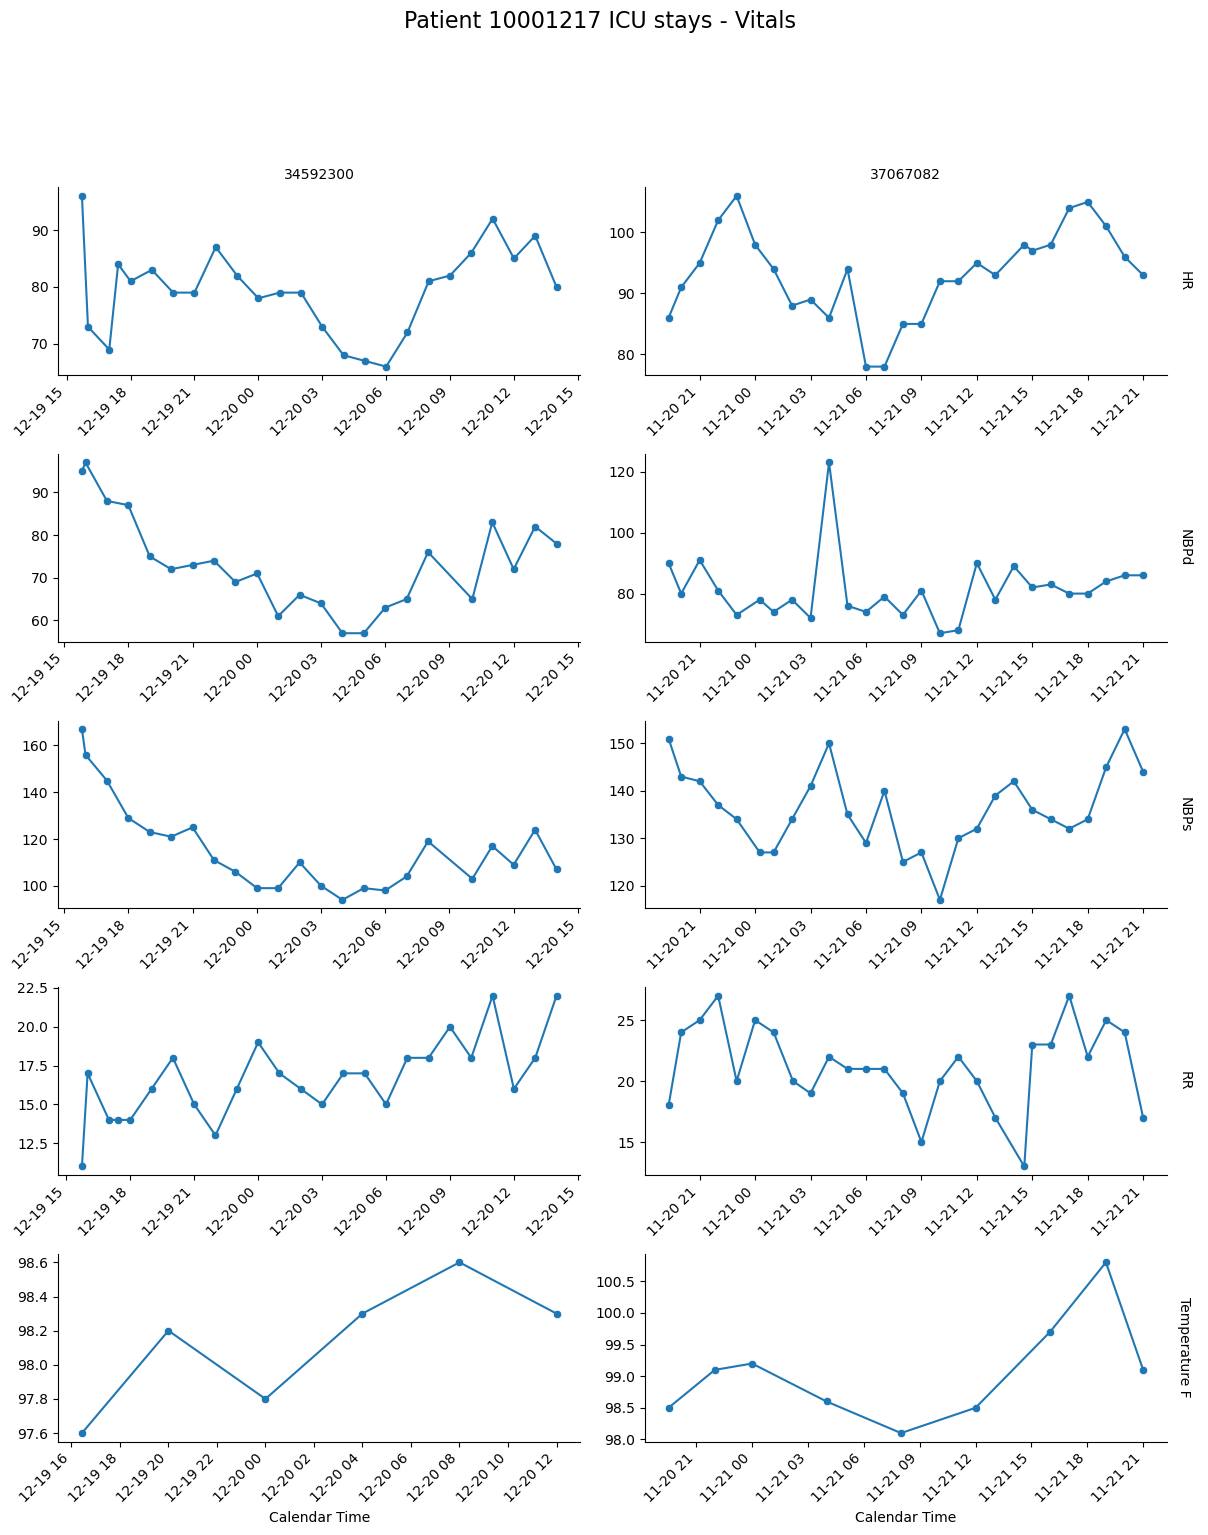

In [124]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(15, 10))
g = sns.FacetGrid(chartevents_t, col="stay_id", row="itemid", margin_titles=True, sharex=False, sharey=False, height=3, aspect=2)
g.map(sns.lineplot, 'charttime', 'value')
g.map(sns.scatterplot, 'charttime', 'value')

# Customize the plot
g.set_axis_labels("Calendar Time", "")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend()

# Adjust the plot and add title
plt.subplots_adjust(top=0.9)
g.fig.suptitle(f"Patient {sid} ICU stays - Vitals", fontsize=16, y=1.02)

# Rotate x-axis labels for better readability
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

# Remove legend from individual plots
for ax in g.axes.flatten():
    ax.legend().remove()
    
plt.tight_layout(rect=[0, 0, 1, 0.95])
# Show the plot
plt.show()

## Problem 2. ICU stays

`icustays.csv.gz` (https://mimic.mit.edu/docs/iv/modules/icu/icustays/) contains data about Intensive Care Units (ICU) stays. The first 10 lines are:

In [125]:
!zcat < ~/mimic/icu/icustays.csv.gz | head

subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.4102662037037037
10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.4975347222222222
10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.1180324074074075
10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.9481134259259258
10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338587962962963
10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:

### (A). Ingestion

Import `icustays.csv.gz` as a DataFrame `icustays_df`.

In [126]:
# Read the CSV file
icustays_df = pd.read_csv("~/mimic/icu/icustays.csv.gz")

# Display the DataFrame
print(icustays_df)

       subject_id   hadm_id   stay_id  \
0        10000032  29079034  39553978   
1        10000980  26913865  39765666   
2        10001217  24597018  37067082   
3        10001217  27703517  34592300   
4        10001725  25563031  31205490   
...           ...       ...       ...   
73176    19999442  26785317  32336619   
73177    19999625  25304202  31070865   
73178    19999828  25744818  36075953   
73179    19999840  21033226  38978960   
73180    19999987  23865745  36195440   

                                         first_careunit  \
0                    Medical Intensive Care Unit (MICU)   
1                    Medical Intensive Care Unit (MICU)   
2                   Surgical Intensive Care Unit (SICU)   
3                   Surgical Intensive Care Unit (SICU)   
4      Medical/Surgical Intensive Care Unit (MICU/SICU)   
...                                                 ...   
73176               Surgical Intensive Care Unit (SICU)   
73177  Medical/Surgical Intensive C

### (B). Summary and visualization

How many unique `subject_id`? Can a `subject_id` have multiple ICU stays? Summarize the number of ICU stays per `subject_id` by graphs.

In [127]:
# Count the number of ICU stays per patient
icu_stays_count = icustays_df['subject_id'].value_counts().reset_index()
icu_stays_count.columns = ['subject_id', 'icu_stays']

# Display the number of unique patients
unique_patients = icu_stays_count['subject_id'].nunique()
print(f"Number of unique patients: {unique_patients}")

Number of unique patients: 50920


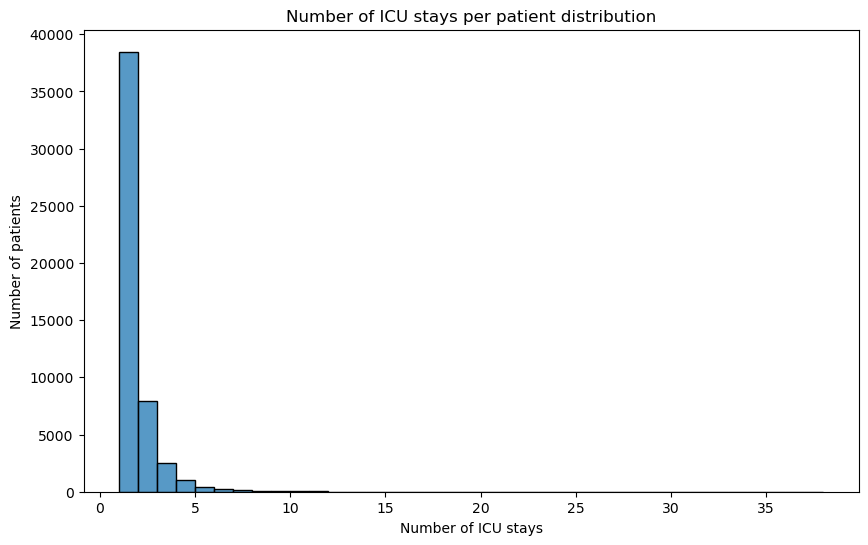

In [128]:
plt.figure(figsize=(10, 6))
sns.histplot(icu_stays_count['icu_stays'], bins=range(1, icu_stays_count['icu_stays'].max() + 2), kde=False)
plt.xlabel("Number of ICU stays")
plt.ylabel("Number of patients")
plt.title("Number of ICU stays per patient distribution")
plt.show()

There are 50920 unique `subject_id`. Also, a `subject_id` can have multiple ICU stays. From the graph, we know most patients have only 1 ICU stay.

## Problem 3. `admissions` data

Information of the patients admitted into hospital is available in `admissions.csv.gz`. See https://mimic.mit.edu/docs/iv/modules/hosp/admissions/ for details of each field in this file. The first 10 lines are

In [129]:
!zcat < ~/mimic/hosp/admissions.csv.gz | head

subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,,EU OBSERVATION,P51VDL,EMERGENCY ROOM,,Other,ENGLISH,SINGLE,WHIT

### (A). Ingestion
Import `admissions.csv.gz` as a data frame `admissions_df`.

In [130]:
# Read the CSV file
admissions_df = pd.read_csv("~/mimic/hosp/admissions.csv.gz")

# Display the DataFrame
print(admissions_df)


        subject_id   hadm_id            admittime            dischtime  \
0         10000032  22595853  2180-05-06 22:23:00  2180-05-07 17:15:00   
1         10000032  22841357  2180-06-26 18:27:00  2180-06-27 18:49:00   
2         10000032  25742920  2180-08-05 23:44:00  2180-08-07 17:50:00   
3         10000032  29079034  2180-07-23 12:35:00  2180-07-25 17:55:00   
4         10000068  25022803  2160-03-03 23:16:00  2160-03-04 06:26:00   
...            ...       ...                  ...                  ...   
431226    19999828  25744818  2149-01-08 16:44:00  2149-01-18 17:00:00   
431227    19999828  29734428  2147-07-18 16:23:00  2147-08-04 18:10:00   
431228    19999840  21033226  2164-09-10 13:47:00  2164-09-17 13:42:00   
431229    19999840  26071774  2164-07-25 00:27:00  2164-07-28 12:15:00   
431230    19999987  23865745  2145-11-02 21:38:00  2145-11-11 12:57:00   

                  deathtime  admission_type admit_provider_id  \
0                       NaN          URGENT   

### (B). Summary and visualization

Summarize the following information by graphics and explain any patterns you see.

- number of admissions per patient
- admission hour of day (anything unusual?)
- admission minute (anything unusual?)
- length of hospital stay (from admission to discharge) (anything unusual?)

According to the MIMIC-IV documentation:

> All dates in the database have been shifted to protect patient confidentiality. Dates will be internally consistent for the same patient, but randomly distributed in the future. Dates of birth which occur in the present time are not true dates of birth. Furthermore, dates of birth which occur before the year 1900 occur if the patient is older than 89. In these cases, the patient’s age at their first admission has been fixed to 300.

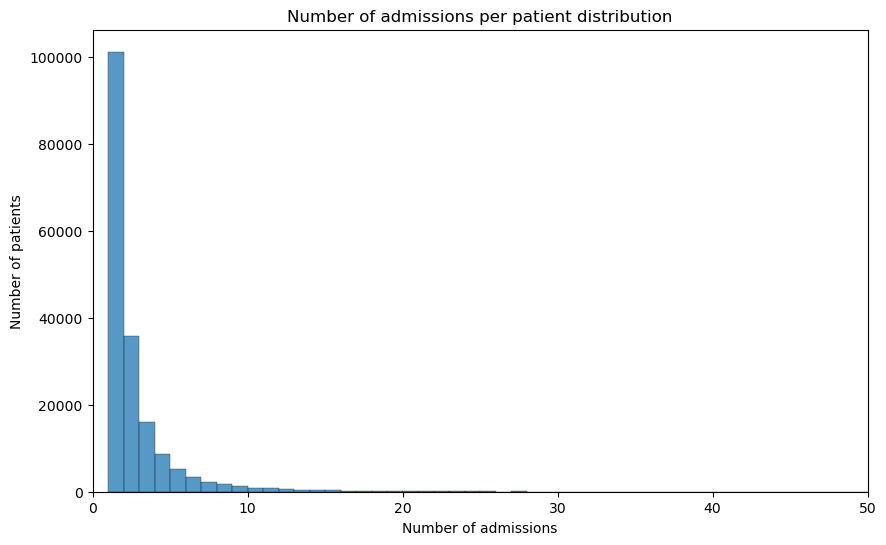

In [131]:
# Count the number of admissions per patient
admissions_count = admissions_df['subject_id'].value_counts().reset_index()
admissions_count.columns = ['subject_id', 'admissions']

# Plot the distribution of admissions per patient
plt.figure(figsize=(10, 6))
sns.histplot(admissions_count['admissions'], bins=range(1, admissions_count['admissions'].max() + 2), kde=False)
plt.xlim(0, 50)
plt.xlabel("Number of admissions")
plt.ylabel("Number of patients")
plt.title("Number of admissions per patient distribution")
plt.show()

Most patients have only one admission, and number of patients will decrease along with increase of number of admissions.

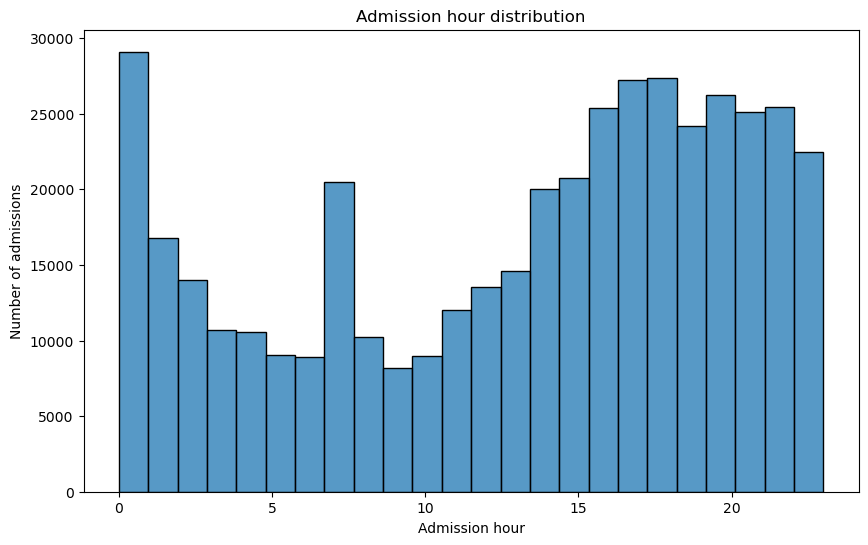

In [132]:
# Convert 'admittime' to datetime
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])

# Extract the hour from 'admittime'
admissions_df['admission_hour'] = admissions_df['admittime'].dt.hour

# Plot the distribution of admission hours
plt.figure(figsize=(10, 6))
sns.histplot(admissions_df['admission_hour'], bins=24, kde=False)
plt.xlabel("Admission hour")
plt.ylabel("Number of admissions")
plt.title("Admission hour distribution")
plt.show()

Most admissions occur from 14 to 24, and the number of admissions is relatively low from 0 to 13. However, from 0 to 13, there is a significant high admissions at 7, which is the wake-up time for most people.

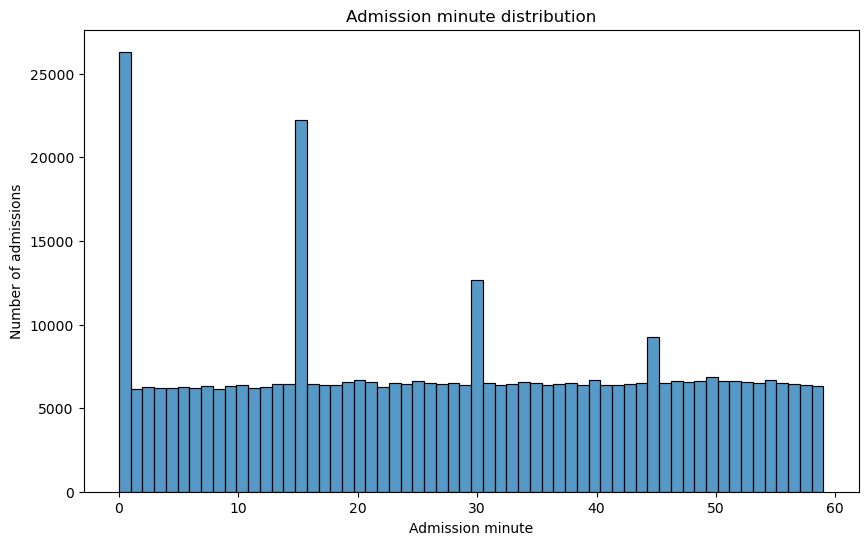

In [133]:
# Extract the minute from 'admittime'
admissions_df['admission_minute'] = admissions_df['admittime'].dt.minute

# Plot the distribution of admission minutes
plt.figure(figsize=(10, 6))
sns.histplot(admissions_df['admission_minute'], bins=60, kde=False)
plt.xlabel("Admission minute")
plt.ylabel("Number of admissions")
plt.title("Admission minute distribution")
plt.show()

There are significant high admissions occurring at minute 0, minute 15, minute 30, and minute 45, along with a decreasing trend, which is consistent with the practice of rounding time to the nearest quarter hour.

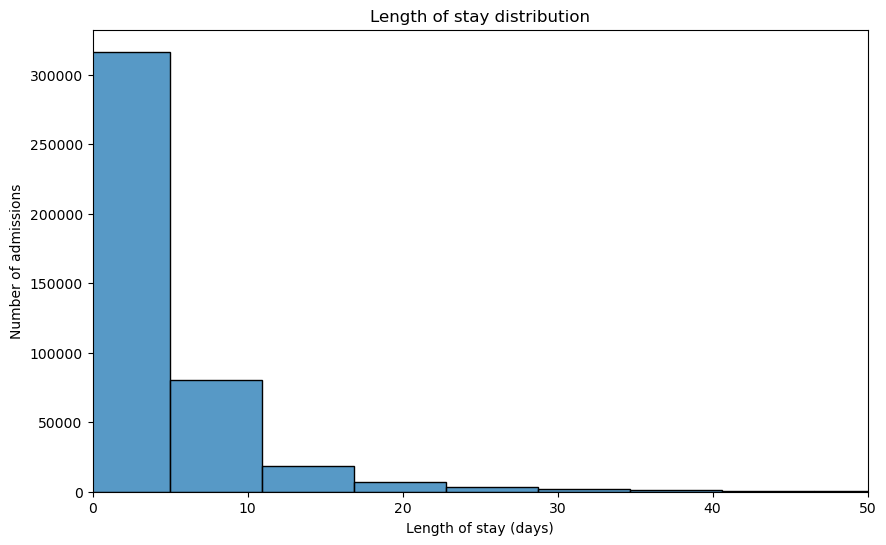

In [134]:
# Convert 'dischtime' to datetime
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])

# Calculate the length of stay in days
admissions_df['length_of_stay'] = (admissions_df['dischtime'] - admissions_df['admittime']).dt.total_seconds() / (24 * 60 * 60)

# Plot the distribution of length of stay
plt.figure(figsize=(10, 6))
sns.histplot(admissions_df['length_of_stay'].dropna(), bins=50, kde=False)
plt.xlim(0, 50)
plt.xlabel("Length of stay (days)")
plt.ylabel("Number of admissions")
plt.title("Length of stay distribution")
plt.show()

Most patients stay in hospital for less than 5 days, and the number of admissions will decrease rapidly along with the increase of length of stay.

## Problem 4. `patients` data
Patient information is available in `patients.csv.gz`. See https://mimic.mit.edu/docs/iv/modules/hosp/patients/ for details of each field in this file. The first 10 lines are:

In [135]:
!zcat < ~/mimic/hosp/patients.csv.gz | head

subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
10000032,F,52,2180,2014 - 2016,2180-09-09
10000048,F,23,2126,2008 - 2010,
10000068,F,19,2160,2008 - 2010,
10000084,M,72,2160,2017 - 2019,2161-02-13
10000102,F,27,2136,2008 - 2010,
10000108,M,25,2163,2014 - 2016,
10000115,M,24,2154,2017 - 2019,
10000117,F,48,2174,2008 - 2010,
10000178,F,59,2157,2017 - 2019,
zcat: error writing to output: Broken pipe


### (A). Ingestion
Import `patients.csv.gz` (https://mimic.mit.edu/docs/iv/modules/hosp/patients/) as a data frame `patients_df`.

In [136]:
# Read the CSV file
patients_df = pd.read_csv("~/mimic/hosp/patients.csv.gz")

# Display the DataFrame
print(patients_df)

        subject_id gender  anchor_age  anchor_year anchor_year_group  \
0         10000032      F          52         2180       2014 - 2016   
1         10000048      F          23         2126       2008 - 2010   
2         10000068      F          19         2160       2008 - 2010   
3         10000084      M          72         2160       2017 - 2019   
4         10000102      F          27         2136       2008 - 2010   
...            ...    ...         ...          ...               ...   
299707    19999828      F          46         2147       2017 - 2019   
299708    19999829      F          28         2186       2008 - 2010   
299709    19999840      M          58         2164       2008 - 2010   
299710    19999914      F          49         2158       2017 - 2019   
299711    19999987      F          57         2145       2011 - 2013   

               dod  
0       2180-09-09  
1              NaN  
2              NaN  
3       2161-02-13  
4              NaN  
...      

### (B). Summary and visaulization
Summarize variables `gender` and `anchor_age` by graphics, and explain any patterns you see.

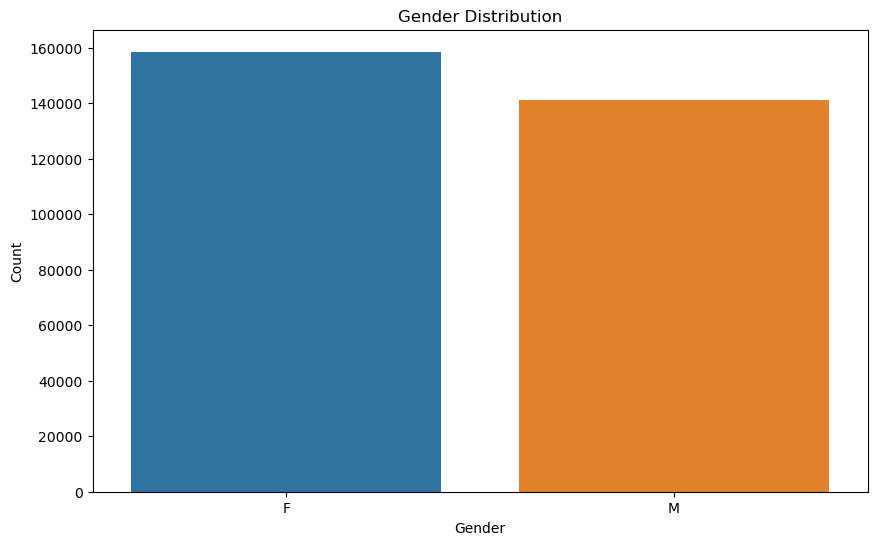

In [137]:
# Bar plot of gender distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', data=patients_df)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Distribution")
plt.show()

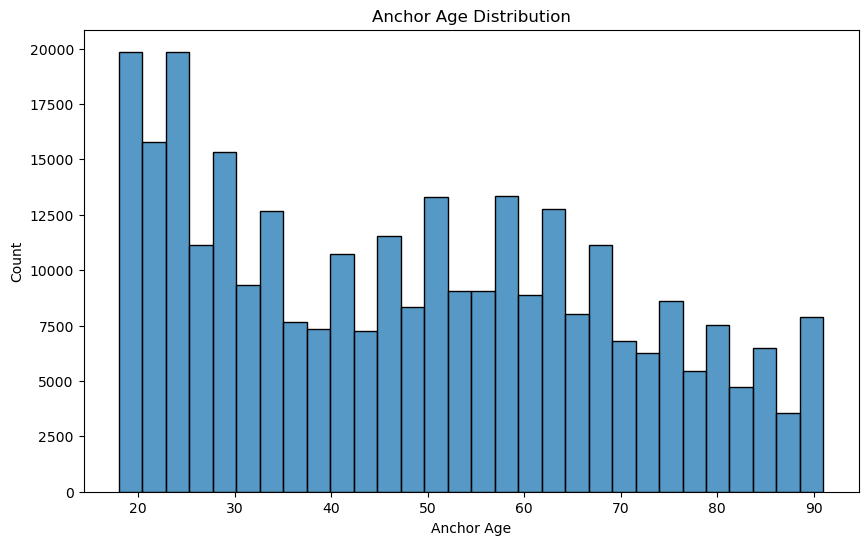

In [138]:
# Histogram of anchor age
plt.figure(figsize=(10, 6))
sns.histplot(patients_df['anchor_age'], bins=30, kde=False)
plt.xlabel("Anchor Age")
plt.ylabel("Count")
plt.title("Anchor Age Distribution")
plt.show()

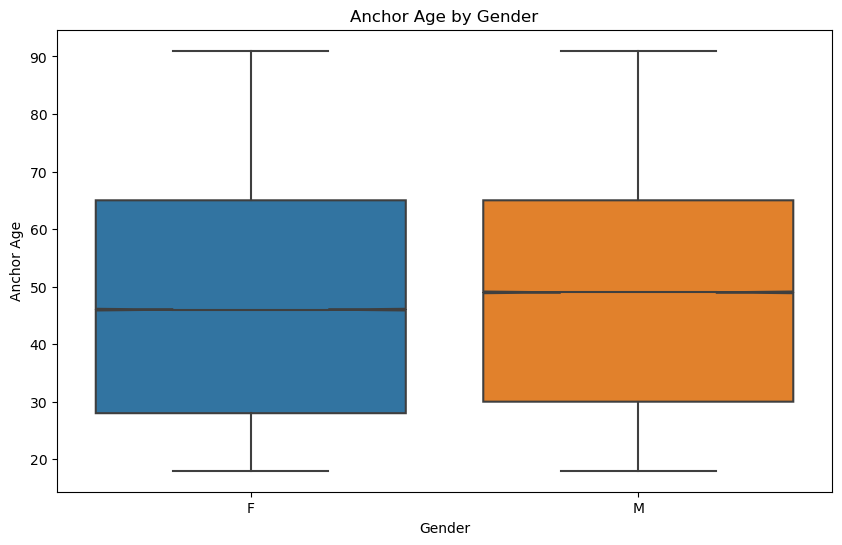

In [139]:
# Box plot of anchor age by gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='anchor_age', data=patients_df, notch=True)
plt.xlabel("Gender")
plt.ylabel("Anchor Age")
plt.title("Anchor Age by Gender")
plt.show()

From graphs, we can see that male patients are a little less than female patients. Also, the age of patients is approximately normally distributed, except for a significant high number of patients afrom age 12-15, which is consistent with the practice of date shifting.

For anchor age distribution, a lot of patients are at range of 19 - 28. After 32, the distribution is approximately following a normal distribution.

In addition, when combining these two variables, the median of anchor_age of Female is less than male. The range of anchor_age for both female and male are approximately same.

## Problem 5. Lab results
labevents.csv.gz (https://mimic.mit.edu/docs/iv/modules/hosp/labevents/) contains all laboratory measurements for patients. The first 10 lines are

In [140]:
!zcat < ~/mimic/hosp/labevents.csv.gz | head

labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
1,10000032,,45421181,51237,P28Z0X,2180-03-23 11:51:00,2180-03-23 15:15:00,1.4,1.4,,0.9,1.1,abnormal,ROUTINE,
2,10000032,,45421181,51274,P28Z0X,2180-03-23 11:51:00,2180-03-23 15:15:00,___,15.1,sec,9.4,12.5,abnormal,ROUTINE,VERIFIED.
3,10000032,,52958335,50853,P28Z0X,2180-03-23 11:51:00,2180-03-25 11:06:00,___,15,ng/mL,30,60,abnormal,ROUTINE,NEW ASSAY IN USE ___: DETECTS D2 AND D3 25-OH ACCURATELY.
4,10000032,,52958335,50861,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,102,102,IU/L,0,40,abnormal,ROUTINE,
5,10000032,,52958335,50862,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,3.3,3.3,g/dL,3.5,5.2,abnormal,ROUTINE,
6,10000032,,52958335,50863,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,109,109,IU/L,35,105,abnormal,ROUTINE,
7,10000032,,52958335,50864,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,___,8,ng/mL,0,8.7,,ROUTI

`d_labitems.csv.gz` (https://mimic.mit.edu/docs/iv/modules/hosp/d_labitems/) is the dictionary of lab measurements.

In [141]:
!zcat < ~/mimic/hosp/d_labitems.csv.gz | head


itemid,label,fluid,category
50801,Alveolar-arterial Gradient,Blood,Blood Gas
50802,Base Excess,Blood,Blood Gas
50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas
50804,Calculated Total CO2,Blood,Blood Gas
50805,Carboxyhemoglobin,Blood,Blood Gas
50806,"Chloride, Whole Blood",Blood,Blood Gas
50808,Free Calcium,Blood,Blood Gas
50809,Glucose,Blood,Blood Gas
50810,"Hematocrit, Calculated",Blood,Blood Gas


We are interested in the lab measurements of creatinine (50912), potassium (50971), sodium (50983), chloride (50902), bicarbonate (50882), hematocrit (51221), white blood cell count (51301), and glucose (50931). Retrieve a subset of `labevents.csv.gz` that only containing these items for the patients in `icustays_df`. Further restrict to the last available measurement (by `storetime`) before the ICU stay. The final `labevents_df` should have one row per ICU stay and columns for each lab measurement.
(ten columns with column names `subject_id`, `stay_id`, `Bicarbonate`, `Chloride`, ...)


_Hint_: Use the Parquet format you generated in Homework 3. For reproducibility, make `labevents.parquet` file available at the current working directory, for example, by a symbolic link.

In [142]:
# Open the dataset
labevents_tble = ds.dataset("labevents.parquet", format="parquet")

# Define the item IDs of interest
lab_item_ids = [50912, 50971, 50983, 50902, 50882, 51221, 51301, 50931]

# Filter the dataset
labevents_filtered = labevents_tble.to_table(filter=(ds.field('itemid').isin(lab_item_ids)))
labevents_filtered = labevents_filtered.select(['subject_id', 'itemid', 'storetime', 'valuenum']).to_pandas()

# Read icustays CSV
icustays_tble = icustays_df

# Convert 'storetime' and 'intime' to datetime
labevents_filtered['storetime'] = pd.to_datetime(labevents_filtered['storetime'])
icustays_tble['intime'] = pd.to_datetime(icustays_tble['intime'])

# Join the dataframes
labevents_for_icu_stays = pd.merge(icustays_tble, labevents_filtered, on='subject_id')

# Filter and sort the data
labevents_for_icu_stays = labevents_for_icu_stays[labevents_for_icu_stays['storetime'] < labevents_for_icu_stays['intime']]
labevents_for_icu_stays = labevents_for_icu_stays.sort_values(by=['subject_id', 'stay_id', 'itemid', 'storetime'])
labevents_for_icu_stays = labevents_for_icu_stays.groupby(['subject_id', 'stay_id', 'itemid']).tail(1)

# Select necessary columns
labevents_for_icu_stays = labevents_for_icu_stays[['subject_id', 'stay_id', 'itemid', 'valuenum']]

# Reshape the DataFrame
df_aggregated = labevents_for_icu_stays.groupby(['subject_id', 'stay_id', 'itemid'])['valuenum'].first().reset_index()
df_pivoted = df_aggregated.pivot_table(index=['subject_id', 'stay_id'], columns='itemid', values='valuenum').reset_index()
df_pivoted.columns = [f'item_{col}' if isinstance(col, int) else col for col in df_pivoted.columns]

# Rename columns
labevents_tble = df_pivoted.rename(columns={
    'item_50912': 'creatinine',
    'item_50971': 'potassium',
    'item_50983': 'sodium',
    'item_50902': 'chloride',
    'item_50882': 'bicarbonate',
    'item_51221': 'hematocrit',
    'item_51301': 'wbc',
    'item_50931': 'glucose'
})

# Display the DataFrame
print(labevents_tble)

       subject_id   stay_id  bicarbonate  chloride  creatinine  glucose  \
0        10000032  39553978         25.0      95.0         0.7    102.0   
1        10000980  39765666         21.0     109.0         2.3     89.0   
2        10001217  34592300         30.0     104.0         0.5     87.0   
3        10001217  37067082         22.0     108.0         0.6    112.0   
4        10001725  31205490          NaN      98.0         NaN      NaN   
...           ...       ...          ...       ...         ...      ...   
68454    19999442  32336619         28.0     105.0         0.9     95.0   
68455    19999625  31070865         20.0     115.0         3.2    248.0   
68456    19999828  36075953         14.0     104.0         0.7    334.0   
68457    19999840  38978960         25.0      98.0         0.8     85.0   
68458    19999987  36195440          NaN       NaN         1.4      NaN   

       potassium  sodium  hematocrit   wbc  
0            6.7   126.0        41.1   6.9  
1        

## Problem 6. Vitals from charted events

`chartevents.csv.gz` (https://mimic.mit.edu/docs/iv/modules/icu/chartevents/) contains all the charted data available for a patient. During their ICU stay, the primary repository of a patient’s information is their electronic chart. The `itemid` variable indicates a single measurement type in the database. The `value` variable is the value measured for `itemid`. The first 10 lines of `chartevents.csv.gz` are

In [143]:
!zcat < ~/mimic/icu/chartevents.csv.gz | head

subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220179,82,82,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220180,59,59,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220181,63,63,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220045,94,94,bpm,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220179,85,85,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220180,55,55,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220181,62,62,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220210,20,20,insp/min,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220277,95,95,%,0
zcat: error writing to output: Broken pipe


`d_items.csv.gz` (https://mimic.mit.edu/docs/iv/modules/icu/d_items/) is the dictionary for the itemid in `chartevents.csv.gz`.

In [144]:
!zcat < ~/mimic/icu/d_items.csv.gz | head

itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
220001,Problem List,Problem List,chartevents,General,,Text,,
220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,,Date and time,,
220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,,
220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,,
220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,,
220048,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,,Text,,
220050,Arterial Blood Pressure systolic,ABPs,chartevents,Routine Vital Signs,mmHg,Numeric,90,140
220051,Arterial Blood Pressure diastolic,ABPd,chartevents,Routine Vital Signs,mmHg,Numeric,60,90
220052,Arterial Blood Pressure mean,ABPm,chartevents,Routine Vital Signs,mmHg,Numeric,,
zcat: error writing to output: Broken pipe


We are interested in the vitals for ICU patients: heart rate (220045), systolic non-invasive blood pressure (220179), diastolic non-invasive blood pressure (220180), body temperature in Fahrenheit (223761), and respiratory rate (220210). Retrieve a subset of `chartevents.csv.gz` only containing these items for the patients in `icustays_tble`. Further restrict to the first vital measurement within the ICU stay. The final `chartevents_tble` should have one row per ICU stay and columns for each vital measurement.

Hint: Use the Parquet format you generated in Homework 3. For reproducibility, make `chartevents.parquet` file available at the current working directory, for example, by a symbolic link.

In [145]:
# import pyarrow as pa
# import pyarrow.csv as pv
# import pyarrow.parquet as pq

# # Define the path to the input CSV file and the output Parquet file.
# in_path = '~/mimic/icu/chartevents.csv.gz'
# out_path = 'chartevents.parquet'

# # Initialize a variable to hold the Parquet writer object.
# writer = None

# # Open the CSV file for reading. This method allows processing the file in chunks.
# with pv.open_csv(in_path) as reader:
#     # Iterate over chunks of the CSV file.
#     while True:
#         try:
#             # Read the next chunk of the CSV file
#             next_chunk = reader.read_next_batch()
#         except StopIteration:
#             # Break the loop if no more data is available (end of file).
#             break

#         # Initialize the Parquet writer with the schema of the first chunk if it hasn't been initialized.
#         if writer is None:
#             writer = pq.ParquetWriter(out_path, next_chunk.schema)
        
#         # Convert the current chunk into a PyArrow Table.
#         next_table = pa.Table.from_batches([next_chunk])
        
#         # Write the Table to the Parquet file.
#         writer.write_table(next_table)

# # Ensure to close the Parquet writer to finalize the file and free resources.
# if writer is not None:
#     writer.close()

In [146]:
# Open the dataset
chartevents_tble = ds.dataset("chartevents.parquet", format="parquet")

# Define the item IDs of interest
item_ids = [220045, 220179, 220180, 223761, 220210]

# Filter the dataset
chartevents_filtered = chartevents_tble.to_table(filter=ds.field('itemid').isin(item_ids)).to_pandas()

# Select necessary columns
chartevents_filtered = chartevents_filtered[['subject_id', 'stay_id', 'charttime', 'itemid', 'valuenum']]

# Read icustays CSV
icustays_tble = pd.read_csv("~/mimic/icu/icustays.csv.gz")

# Convert datetime columns
chartevents_filtered['charttime'] = pd.to_datetime(chartevents_filtered['charttime'])
icustays_tble['intime'] = pd.to_datetime(icustays_tble['intime'])
icustays_tble['outtime'] = pd.to_datetime(icustays_tble['outtime'])

# Merge DataFrames
chartevents_for_icu_stays = icustays_tble.merge(chartevents_filtered, on=['subject_id', 'stay_id'])

# Filter based on time
chartevents_for_icu_stays = chartevents_for_icu_stays[
    (chartevents_for_icu_stays['charttime'] >= chartevents_for_icu_stays['intime']) & 
    (chartevents_for_icu_stays['charttime'] <= chartevents_for_icu_stays['outtime'])
]

# Group and sort
chartevents_for_icu_stays = chartevents_for_icu_stays.sort_values(by=['subject_id', 'stay_id', 'itemid', 'charttime'])
chartevents_for_icu_stays = chartevents_for_icu_stays.groupby(['subject_id', 'stay_id', 'itemid']).first().reset_index()

# Select necessary columns
chartevents_for_icu_stays = chartevents_for_icu_stays[['subject_id', 'stay_id', 'itemid', 'valuenum']]

# Pivot the DataFrame
df_pivoted = chartevents_for_icu_stays.pivot_table(index=['subject_id', 'stay_id'], columns='itemid', values='valuenum').reset_index()

# Rename columns
df_pivoted.columns = [f'item_{col}' if isinstance(col, int) else col for col in df_pivoted.columns]
chartevents_tble = df_pivoted.rename(columns={
    'item_220045': 'heart_rate',
    'item_220179': 'non_invasive_blood_pressure_systolic',
    'item_220180': 'non_invasive_blood_pressure_diastolic',
    'item_223761': 'temperature_fahrenheit',
    'item_220210': 'respiratory_rate'
})

# Display the DataFrame
print(chartevents_tble)

       subject_id   stay_id  heart_rate  non_invasive_blood_pressure_systolic  \
0        10000032  39553978        91.0                                  84.0   
1        10000980  39765666        77.0                                 150.0   
2        10001217  34592300        96.0                                 167.0   
3        10001217  37067082        86.0                                 151.0   
4        10001725  31205490        55.0                                  73.0   
...           ...       ...         ...                                   ...   
73159    19999442  32336619        88.0                                 150.0   
73160    19999625  31070865        96.0                                 152.0   
73161    19999828  36075953       104.0                                 113.0   
73162    19999840  38978960       100.0                                 114.0   
73163    19999987  36195440        94.0                                 115.0   

       non_invasive_blood_p

## Problem 7. Putting things together
Let us create a data frame `mimic_icu_cohort` for all ICU stays, where rows are all ICU stays of adults (age at `intime` >= 18) and columns contain at least following variables

- all variables in `icustays_tble`
- all variables in `admissions_tble`
- all variables in `patients_tble`
- the last lab measurements before the ICU stay in `labevents_tble`
- the first vital measurements during the ICU stay in `chartevents_tble`
- The final `mimic_icu_cohort` should have one row per ICU stay and columns for each variable.

In [147]:
# Convert datetime columns
icustays_df['intime'] = pd.to_datetime(icustays_df['intime'])
icustays_df['outtime'] = pd.to_datetime(icustays_df['outtime'])

# Step 1: Merge icustays and admissions tables
mimic_icu_cohort = icustays_df.merge(admissions_df, on=["subject_id", "hadm_id"], how="left")

# Step 2: Merge with patients table and filter by age
mimic_icu_cohort = mimic_icu_cohort.merge(patients_df, on="subject_id", how="left")
mimic_icu_cohort['age_intime'] = mimic_icu_cohort['intime'].dt.year - mimic_icu_cohort['anchor_year'] + mimic_icu_cohort['anchor_age']
mimic_icu_cohort = mimic_icu_cohort[mimic_icu_cohort['age_intime'] >= 18]

# Step 3: Merge with labevents table and keep the last record per group
mimic_icu_cohort = mimic_icu_cohort.merge(labevents_tble, on=["subject_id", "stay_id"], how="left")
mimic_icu_cohort = mimic_icu_cohort.sort_values(by=['subject_id', 'stay_id', 'intime'], ascending=True)
mimic_icu_cohort = mimic_icu_cohort.groupby(['subject_id', 'stay_id']).tail(1).reset_index(drop=True)

# Step 4: Merge with chartevents table and keep the first record per group
mimic_icu_cohort = mimic_icu_cohort.merge(chartevents_tble, on=["subject_id", "stay_id"], how="left")
mimic_icu_cohort = mimic_icu_cohort.sort_values(by=['subject_id', 'stay_id', 'intime'], ascending=True)
mimic_icu_cohort = mimic_icu_cohort.groupby(['subject_id', 'stay_id']).head(1).reset_index(drop=True)

# Display the final DataFrame
print(mimic_icu_cohort)

       subject_id   hadm_id   stay_id  \
0        10000032  29079034  39553978   
1        10000980  26913865  39765666   
2        10001217  27703517  34592300   
3        10001217  24597018  37067082   
4        10001725  25563031  31205490   
...           ...       ...       ...   
73176    19999442  26785317  32336619   
73177    19999625  25304202  31070865   
73178    19999828  25744818  36075953   
73179    19999840  21033226  38978960   
73180    19999987  23865745  36195440   

                                         first_careunit  \
0                    Medical Intensive Care Unit (MICU)   
1                    Medical Intensive Care Unit (MICU)   
2                   Surgical Intensive Care Unit (SICU)   
3                   Surgical Intensive Care Unit (SICU)   
4      Medical/Surgical Intensive Care Unit (MICU/SICU)   
...                                                 ...   
73176               Surgical Intensive Care Unit (SICU)   
73177  Medical/Surgical Intensive C

## Problem 8. Exploratory data analysis (EDA)
Summarize the following information about the ICU stay cohort `mimic_icu_cohort` using appropriate method:

- Length of ICU stay `los` vs demographic variables (race, insurance, marital_status, gender, age at intime)

- Length of ICU stay `los` vs the last available lab measurements before ICU stay

- Length of ICU stay `los` vs the first vital measurements within the ICU stay

- Length of ICU stay `los` vs first ICU unit

At least two plots should be created, with at least one them including multiple facets using an appropriate keyword argument. 

## Answer:

1.
Length of ICU stay los vs demographic variables (race, insurance, marital_status, gender, age at intime)

Boxplot for categorical variables:

Race:

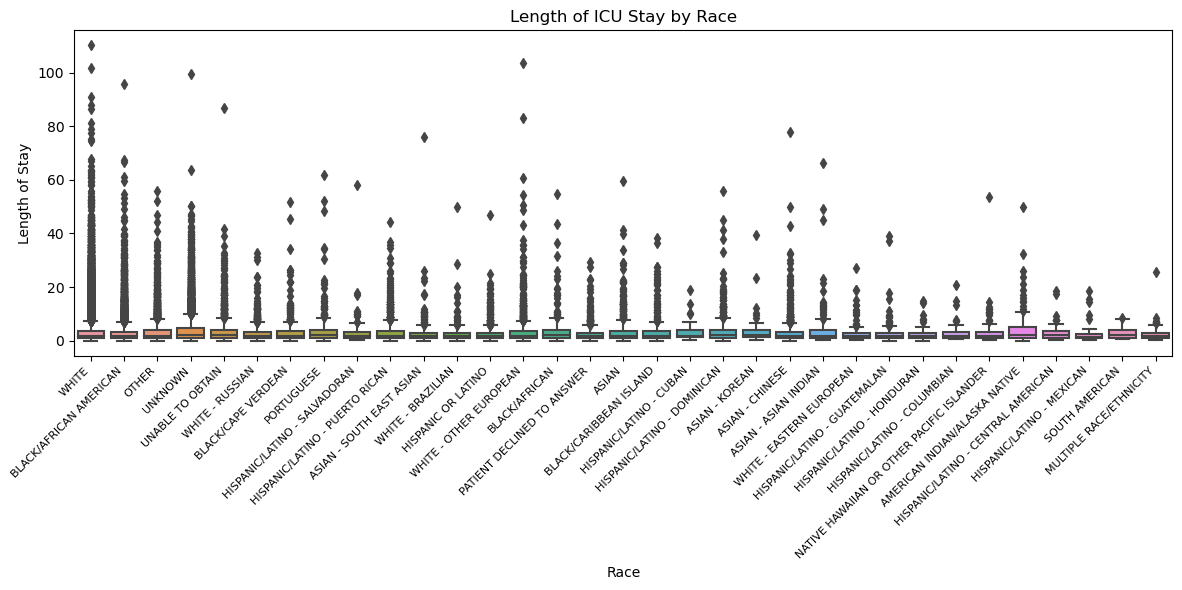

In [148]:
import matplotlib.pyplot as plt

# Convert 'los' to numeric if it's not already
mimic_icu_cohort['los'] = pd.to_numeric(mimic_icu_cohort['los'], errors='coerce')

# Create a boxplot of Length of ICU Stay by Race
plt.figure(figsize=(12, 6))
sns.boxplot(data=mimic_icu_cohort, x='race', y='los')
plt.title("Length of ICU Stay by Race")
plt.xlabel("Race")
plt.ylabel("Length of Stay")
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate x-axis labels
plt.tight_layout()

# Display the plot
plt.show()

Insurance:

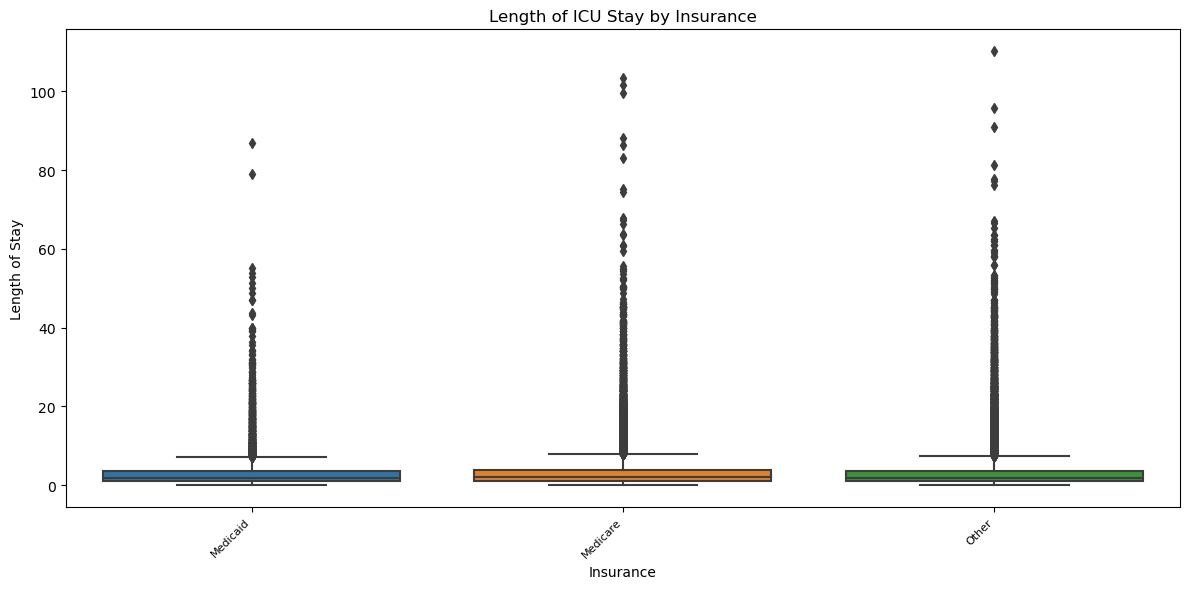

In [149]:
# Create a boxplot of Length of ICU Stay by Insurance
plt.figure(figsize=(12, 6))
sns.boxplot(data=mimic_icu_cohort, x='insurance', y='los')
plt.title("Length of ICU Stay by Insurance")
plt.xlabel("Insurance")
plt.ylabel("Length of Stay")
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate x-axis labels
plt.tight_layout()

# Display the plot
plt.show()

Marital Status:

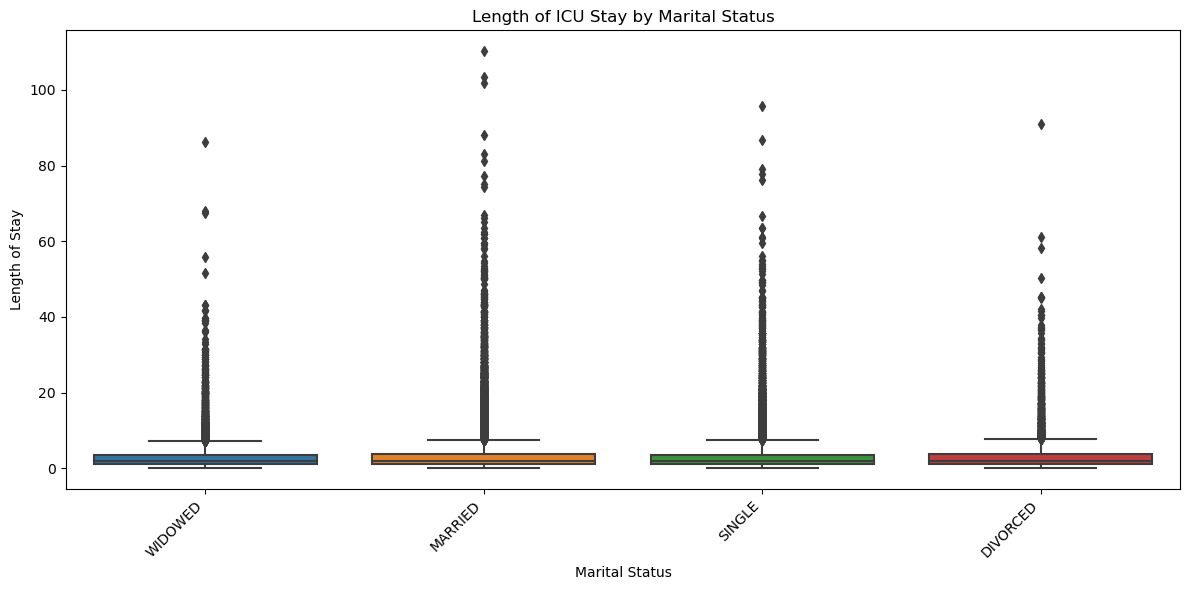

In [150]:
# Create a boxplot of Length of ICU Stay by Marital Status
plt.figure(figsize=(12, 6))
sns.boxplot(data=mimic_icu_cohort, x='marital_status', y='los')
plt.title("Length of ICU Stay by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Length of Stay")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()

# Display the plot
plt.show()

Gender:

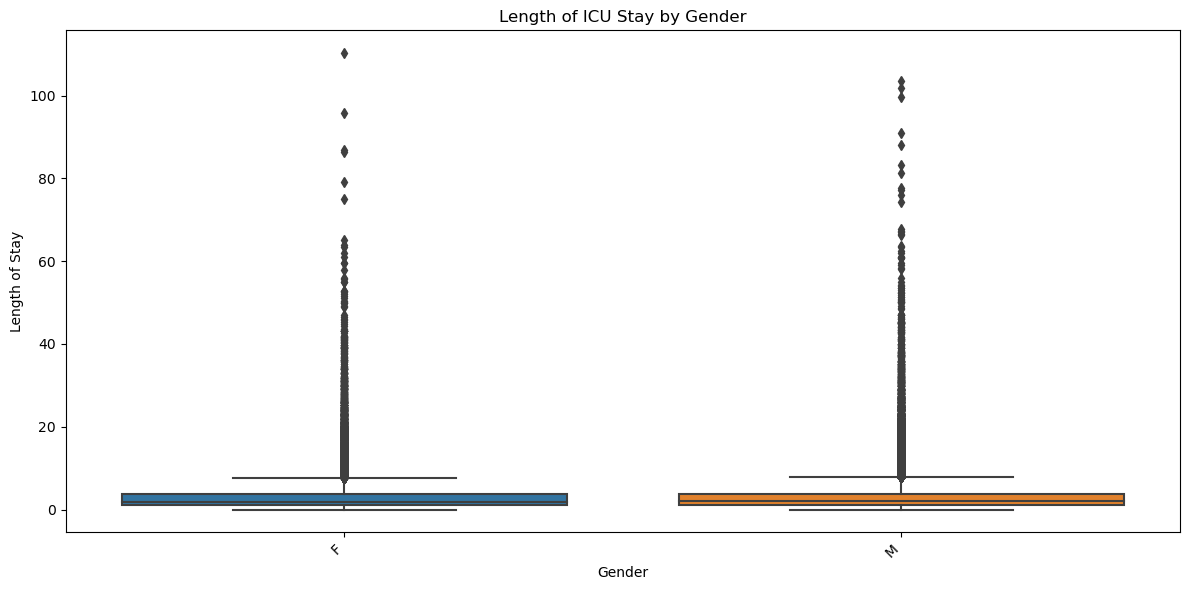

In [151]:
# Create a boxplot of Length of ICU Stay by Gender
plt.figure(figsize=(12, 6))
sns.boxplot(data=mimic_icu_cohort, x='gender', y='los')
plt.title("Length of ICU Stay by Gender")
plt.xlabel("Gender")
plt.ylabel("Length of Stay")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()

# Display the plot
plt.show()

Scatter plot for continuous variable age at intime:

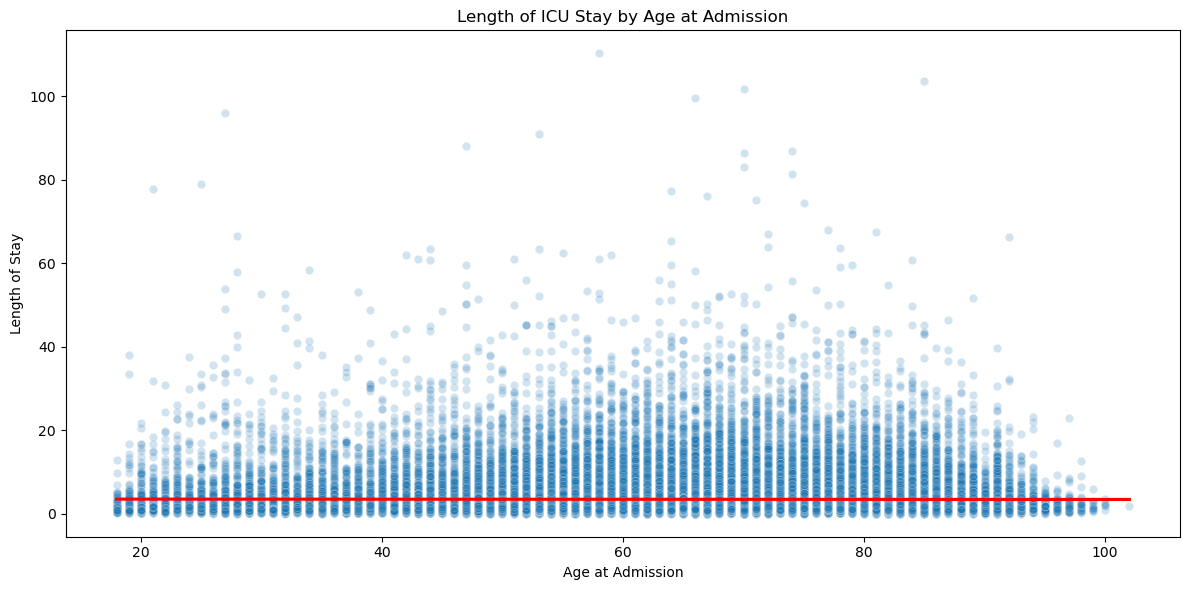

In [152]:
# Create a scatter plot of Length of ICU Stay by Age at Admission
plt.figure(figsize=(12, 6))
sns.scatterplot(data=mimic_icu_cohort, x='age_intime', y='los', alpha=0.2)
sns.regplot(data=mimic_icu_cohort, x='age_intime', y='los', scatter=False, color='red')
plt.title("Length of ICU Stay by Age at Admission")
plt.xlabel("Age at Admission")
plt.ylabel("Length of Stay")
plt.tight_layout()

# Display the plot
plt.show()

These variables do not have a obvious difference on length of ICU stay.

2.
Length of ICU stay los vs the last available lab measurements before ICU stay

data wrangling

In [153]:
# Select the relevant columns and pivot longer
labs_long = mimic_icu_cohort.melt(
    id_vars=['stay_id', 'los'],
    value_vars=['bicarbonate', 'chloride', 'creatinine', 'glucose', 'potassium', 'sodium', 'hematocrit', 'wbc'],
    var_name='lab_measurement',
    value_name='measurement_value'
)

# Display the transformed DataFrame
print(labs_long)

         stay_id       los lab_measurement  measurement_value
0       39553978  0.410266     bicarbonate               25.0
1       39765666  0.497535     bicarbonate               21.0
2       34592300  0.948113     bicarbonate               30.0
3       37067082  1.118032     bicarbonate               22.0
4       31205490  1.338588     bicarbonate                NaN
...          ...       ...             ...                ...
585443  32336619  6.950370             wbc                5.4
585444  31070865  0.960741             wbc               18.6
585445  36075953  1.790995             wbc               26.0
585446  38978960  5.297766             wbc               24.3
585447  36195440  1.937847             wbc               13.5

[585448 rows x 4 columns]


plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

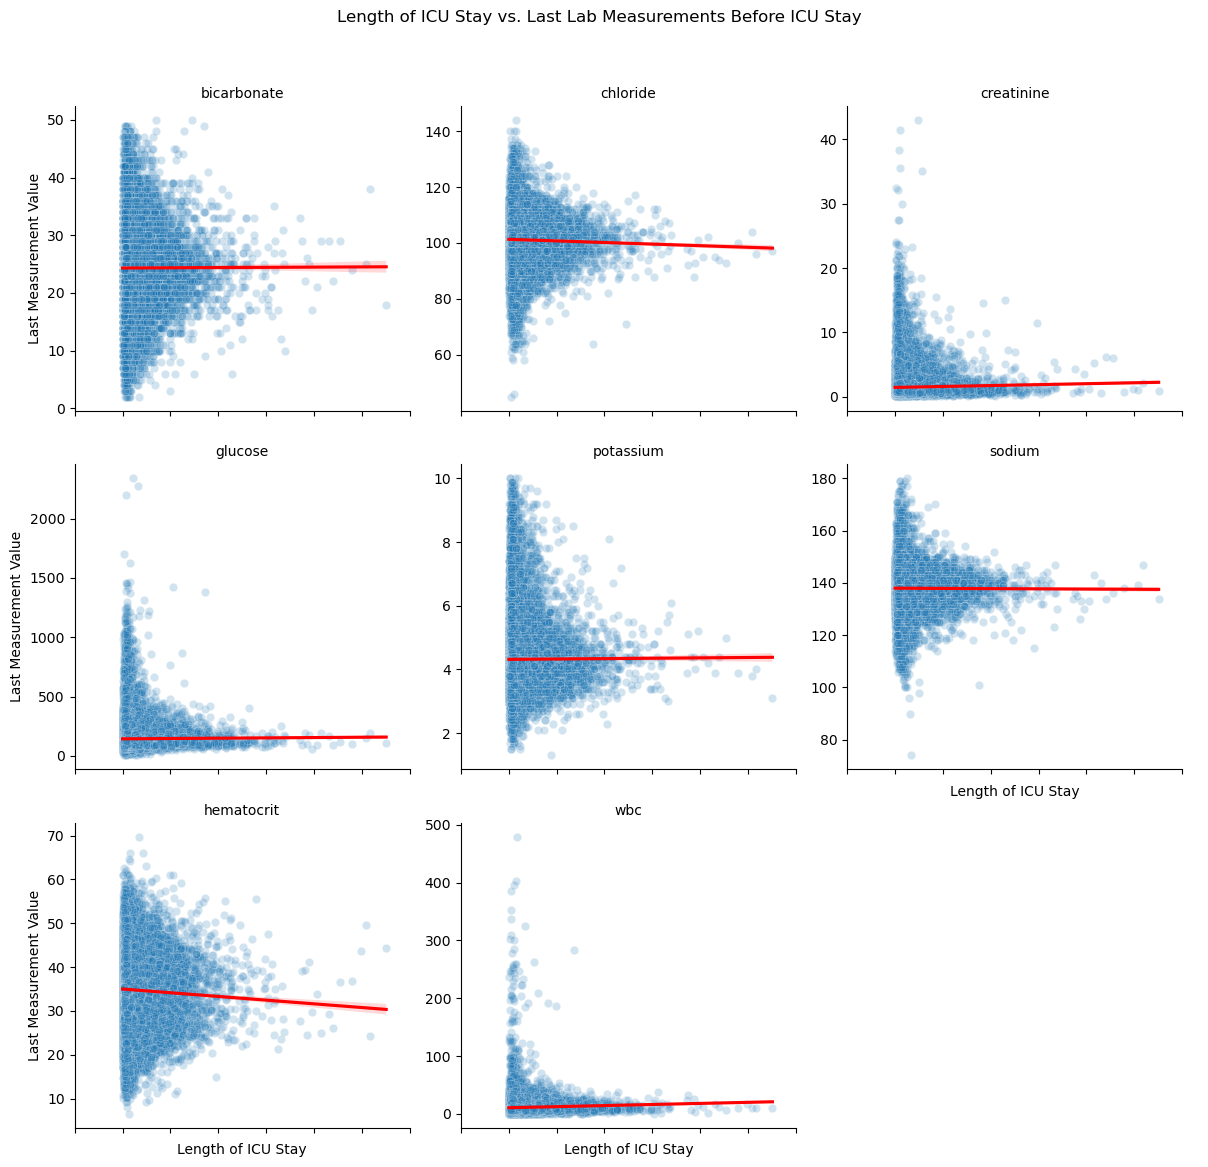

In [154]:
# Create the plot
g = sns.FacetGrid(labs_long, col="lab_measurement", col_wrap=3, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x='los', y='measurement_value', alpha=0.2)
g.map_dataframe(sns.regplot, x='los', y='measurement_value', scatter=False, color='red', line_kws={'label': 'Linear fit'})

# Customize the plot
g.set_axis_labels("Length of ICU Stay", "Last Measurement Value")
g.set_titles(col_template="{col_name}")
g.add_legend()

# Adjust the plot and add title
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Length of ICU Stay vs. Last Lab Measurements Before ICU Stay")
g.set_xticklabels(rotation=45)

# Remove legend from individual plots
for ax in g.axes.flatten():
    ax.legend().remove()

# Show the plot
plt.show()


Chloride and hematocrit have negative relation with length of ICU stay, while creatinine and wbc have positive relation with length of ICU stay. Others do not have obvious relation with length of ICU stay.

3.
Length of ICU stay los vs the first vital measurements within the ICU stay

data wrangling

In [155]:
# Select the relevant columns and pivot longer
vitals_long = mimic_icu_cohort.melt(
    id_vars=['stay_id', 'los'],
    value_vars=['heart_rate', 'non_invasive_blood_pressure_systolic', 
                'non_invasive_blood_pressure_diastolic', 'respiratory_rate', 'temperature_fahrenheit'],
    var_name='vital_sign',
    value_name='measurement_value'
)

# Display the transformed DataFrame
print(vitals_long)

         stay_id       los              vital_sign  measurement_value
0       39553978  0.410266              heart_rate               91.0
1       39765666  0.497535              heart_rate               77.0
2       34592300  0.948113              heart_rate               96.0
3       37067082  1.118032              heart_rate               86.0
4       31205490  1.338588              heart_rate               55.0
...          ...       ...                     ...                ...
365900  32336619  6.950370  temperature_fahrenheit               98.3
365901  31070865  0.960741  temperature_fahrenheit               98.9
365902  36075953  1.790995  temperature_fahrenheit               98.7
365903  38978960  5.297766  temperature_fahrenheit               99.3
365904  36195440  1.937847  temperature_fahrenheit               99.6

[365905 rows x 4 columns]


plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


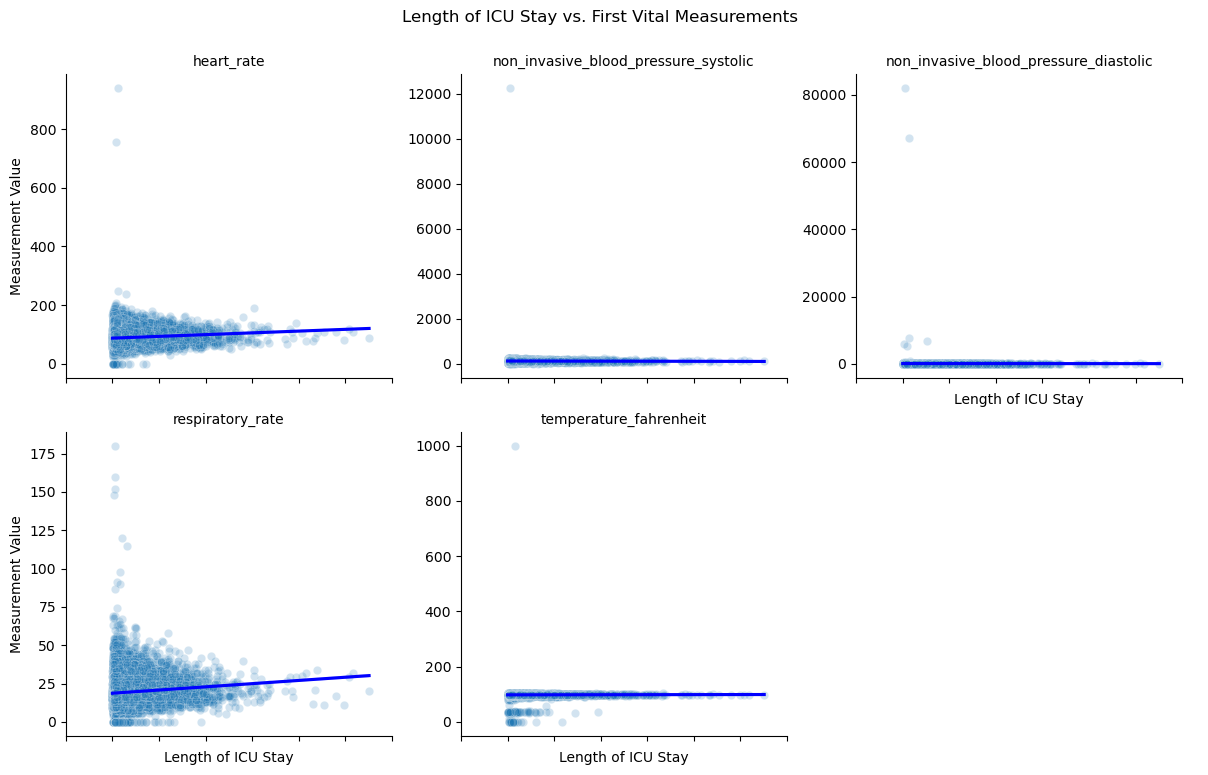

In [156]:
# Create the plot
g = sns.FacetGrid(vitals_long, col="vital_sign", col_wrap=3, sharey=False, height=4)
g.map_dataframe(sns.scatterplot, x='los', y='measurement_value', alpha=0.2)
g.map_dataframe(sns.regplot, x='los', y='measurement_value', scatter=False, color='blue')

# Customize the plot
g.set_axis_labels("Length of ICU Stay", "Measurement Value")
g.set_titles(col_template="{col_name}")
g.add_legend()

# Adjust the plot and add title
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Length of ICU Stay vs. First Vital Measurements")
g.set_xticklabels(rotation=45)

# Remove legend from individual plots
for ax in g.axes.flatten():
    ax.legend().remove()

# Show the plot
plt.show()

From the graph, we see that heart rate and respiratory rate have a increase trend with length of ICU stay, while others do not have obvious relation with length of ICU stay.

4.
Length of ICU stay los vs first ICU unit

summarise the mean length of ICU stay by first ICU unit

In [157]:
# Summarize the mean length of ICU stay by first ICU unit
mean_los_by_unit = mimic_icu_cohort.groupby('first_careunit').agg(mean_los=('los', 'mean')).reset_index()

# Remove NaN values and sort by mean length of stay in descending order
mean_los_by_unit = mean_los_by_unit.dropna().sort_values(by='mean_los', ascending=False)

# Display the summarized DataFrame
print(mean_los_by_unit)


                                     first_careunit  mean_los
6   Neuro Surgical Intensive Care Unit (Neuro SICU)  6.299043
7               Surgical Intensive Care Unit (SICU)  3.837683
8                               Trauma SICU (TSICU)  3.833085
4                                Neuro Intermediate  3.420690
0      Cardiac Vascular Intensive Care Unit (CVICU)  3.290002
2                Medical Intensive Care Unit (MICU)  3.263419
1                          Coronary Care Unit (CCU)  3.192368
3  Medical/Surgical Intensive Care Unit (MICU/SICU)  3.084816
5                                    Neuro Stepdown  2.590663


From numerical summarization, we can see Neuro Surgical Intensive Care Unit (Neuro SICU) has the highest mean_los.

plot

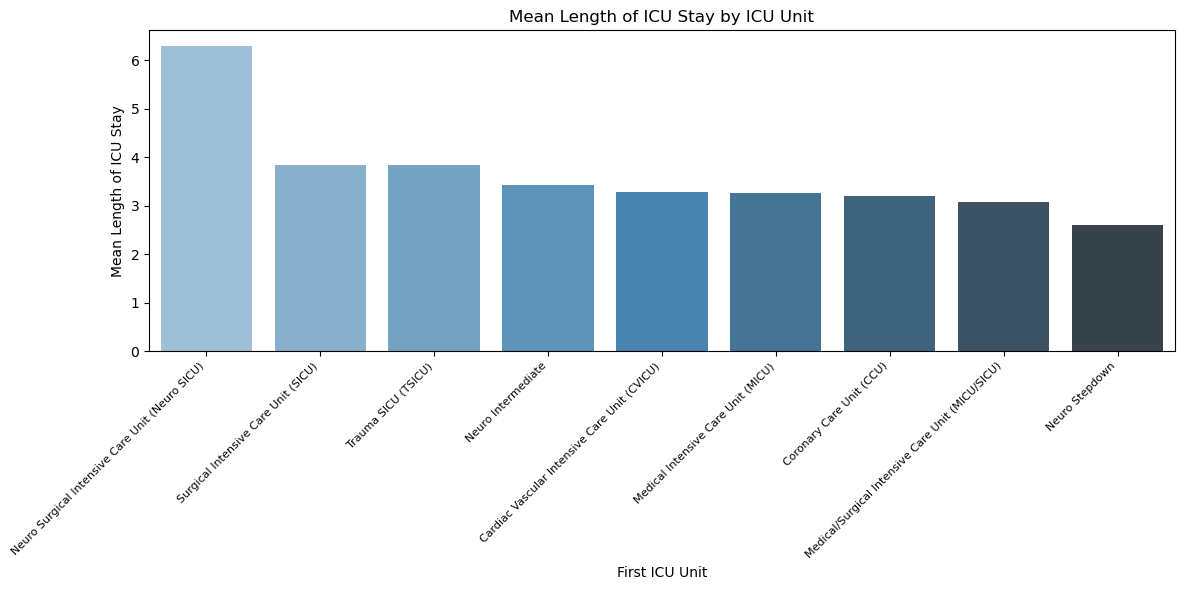

In [158]:
# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_los_by_unit, x='first_careunit', y='mean_los', palette='Blues_d')

# Customize the plot
plt.title("Mean Length of ICU Stay by ICU Unit")
plt.xlabel("First ICU Unit")
plt.ylabel("Mean Length of ICU Stay")
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate x-axis labels

# Display the plot
plt.tight_layout()
plt.show()

Graph shows the same finding with numerical summary.